In [ ]:
import os
from helper_edge_detection import *
from helper_data_normalization import *
from helper_pca import *
from helper_clustering import *
from helper_filtering import *
%matplotlib inline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import pandas as pd

Define constants

In [3]:
DIRECTORY = '/Users/paularescala/Documents/Professional/EPFL/ml-project-2-ml-plume-1/'
PATH_TO_DATA_FOLDER = os.path.join(DIRECTORY + 'rawdata/Training_set')
PATH_TO_DATA_GENERATED = os.path.join(DIRECTORY, 'generated/')

# Pre-processing data

Filter out bad images.

In [4]:
num_images,filenames_new=save_filtered_images(PATH_TO_DATA_FOLDER, PATH_TO_DATA_GENERATED)

Normalize the images using adaptive histogram flattening.

In [5]:
data = normalize_brightness(PATH_TO_DATA_GENERATED, method = 'adaptive_histogram_flattening')

Transform data to images after edge detection applying the roberts and sobel operators.

In [6]:
data_edges_roberts, data_edges_sobel = edge_detection(data)

Perform dimensionality reduction with PCA.

In [7]:
feature_matrix_roberts, imgs_reduced_roberts = apply_pca(data_edges_roberts, 500, plot_explained_variance = False)
feature_matrix_sobel, imgs_reduced_sobel = apply_pca(data_edges_sobel, 500, plot_explained_variance = False)

Before PCA, we have 3600 samples, each with 20480 features
After PCA, we have 3600 samples, each with 500 features
Before PCA, we have 3600 samples, each with 20480 features
After PCA, we have 3600 samples, each with 500 features


# Running kmeans clustering 

In [9]:
def kmeans_full_analysis(data, start, end):
    '''Plot the silhouette scores and sum of squared errors for clustering techniques over values of k.'''
    silhouettes_kmeans = []
    silhouettes_gmm = []
    # Try multiple k
    
    for k in range(start, end):
        # Cluster the data and assigne the labels
        gmm = GaussianMixture(n_components=k)
        gmm = gmm.fit(data)
        labels = KMeans(n_clusters=k, random_state=10).fit_predict(data)
        GMM_labels = gmm.predict(data)
        # Get the Silhouette score
        score = silhouette_score(data, labels)
        silhouettes_kmeans.append({"k": k, "score": score})
        score = silhouette_score(data, GMM_labels)
        silhouettes_gmm.append({"k": k, "score": score})

    # Convert to dataframe
    silhouettes_kmeans = pd.DataFrame(silhouettes_kmeans)
    silhouettes_gmm = pd.DataFrame(silhouettes_gmm)
    
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)

    fig, axs = plt.subplots(3, 1, figsize=(10,10))
    # Plot the data
    axs[0].plot(silhouettes_gmm.k, silhouettes_gmm.score)
    axs[0].set(ylabel="Silhouette score")
    axs[1].plot(silhouettes_kmeans.k, silhouettes_kmeans.score)
    axs[1].set(ylabel="Silhouette score")

    # Plot the data
    axs[2].plot(sse.k, sse.sse)
    plt.xlabel("K")
    axs[2].set(ylabel="Sum of Squared Errors")
    plt.tight_layout()
    
    

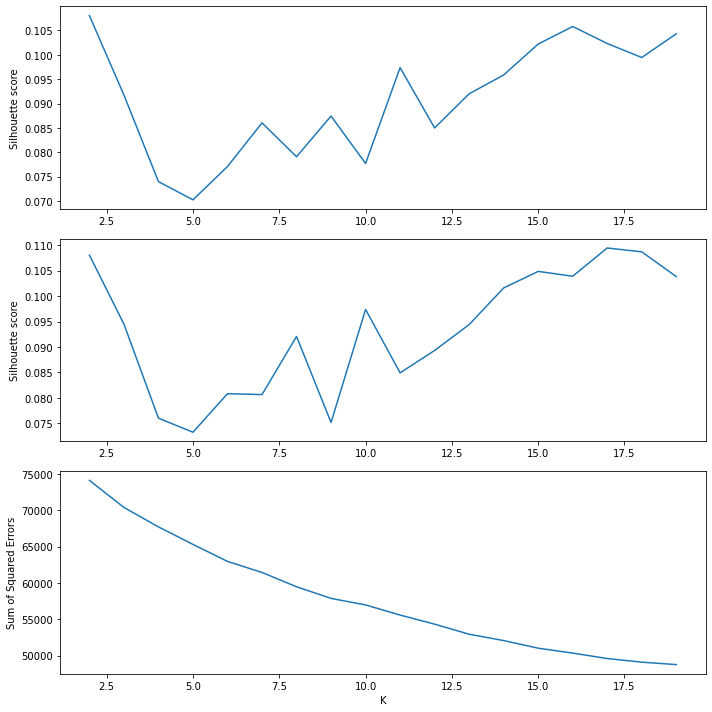

In [10]:
kmeans_full_analysis(feature_matrix_roberts, 2, 20)

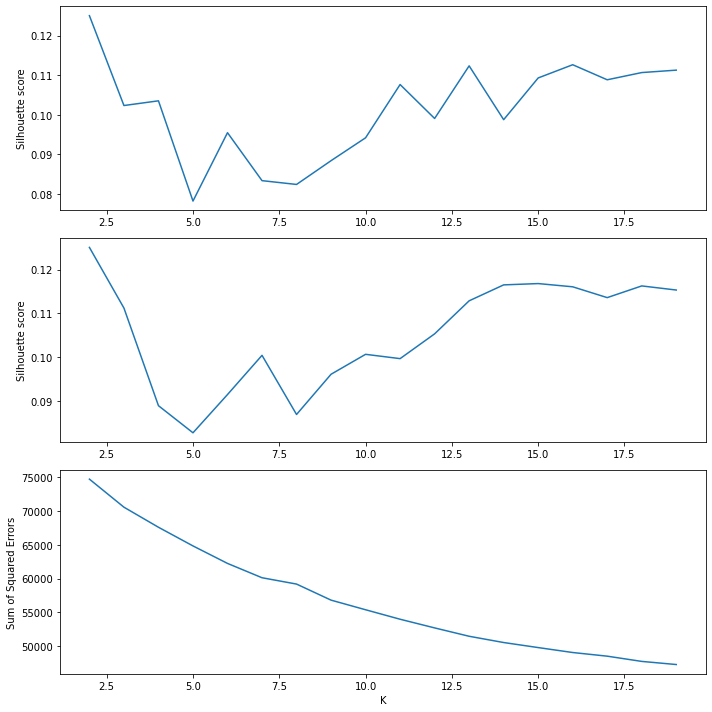

In [11]:
kmeans_full_analysis(feature_matrix_sobel,2,20)

In the following cells, we reduce dimensions of images using tSNE to be able to visualize the clusters in two dimensional space for kmeans and GMM.

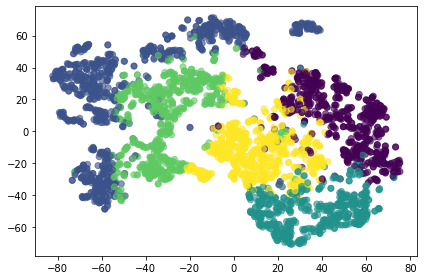

In [12]:
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(feature_matrix_roberts)
labels = KMeans(n_clusters=5, random_state=0).fit_predict(feature_matrix_roberts)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
plt.tight_layout()

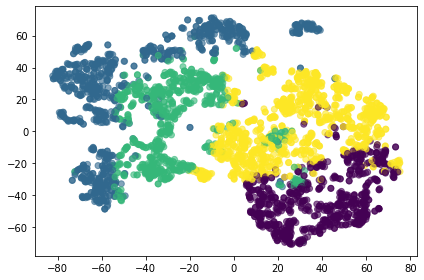

In [13]:
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(feature_matrix_roberts)
labels = KMeans(n_clusters=4, random_state=0).fit_predict(feature_matrix_roberts)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
plt.tight_layout()

In [14]:
gmm = GaussianMixture(n_components=4)
gmm = gmm.fit(feature_matrix_roberts)

In [15]:
GMM_labels = gmm.predict(feature_matrix_roberts)

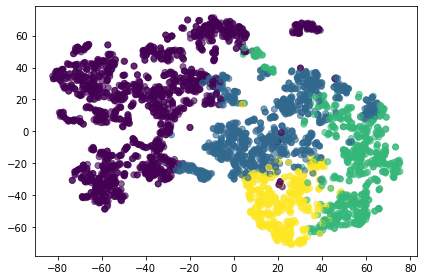

In [16]:
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(feature_matrix_roberts)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1],c=GMM_labels, alpha=0.6)
plt.tight_layout()

In [17]:
labels_df = pd.DataFrame({'names':filenames_new,'gmm':GMM_labels,'kmeans':labels})

In [18]:
labels_df.to_csv('labels_data.csv')